# Toxic comments: exploratory analysis

In [2]:
import pandas as pd, numpy as np

train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Check for missing values:

In [3]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Training/test data sizes:

In [4]:
from __future__ import print_function

nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51.0    : 48.0


In [5]:
from random import sample

train[train.toxic > 0].sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
43357,73ba38b8c891eee1,"""\n\nShorter Gamaliel: Shut up and quit trying...",1,0,0,0,0,0
24512,40c31f152eb0f182,NM \n\nHEY EVERY BITCH HATER (MAINLY KID BITCH...,1,0,1,0,1,0
125519,9f64897a0c2c5f72,"""\n\n Stop being pathetic \n\nDeliberately mis...",1,0,0,0,1,0
105969,36e04839964be16b,Daphne Guinness \n\nTop of the mornin' my favo...,1,0,0,0,0,0
4707,0c796a31496e7d6c,"You can fuck off too, you Twatus Majorus.",1,0,1,0,0,0


Balance of clean vs toxic:

In [6]:
x = train.iloc[:,2:].sum()

# marking comments without any tags as "clean"
rowsums = train.iloc[:,2:].sum(axis=1)
train['clean'] = (rowsums==0)

# count number of clean entries
train['clean'].sum()

print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


How long are comments? Here's the distribution of the number of words:

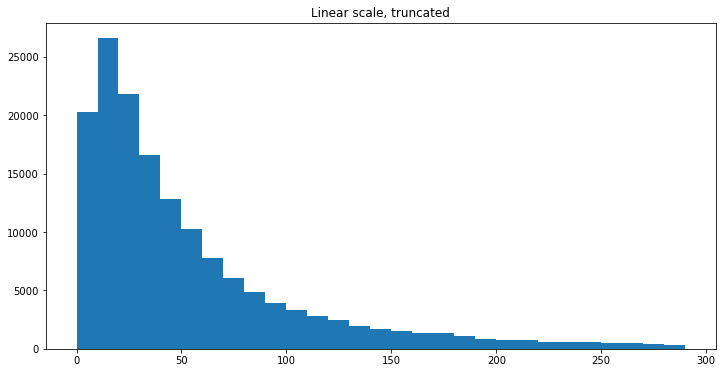

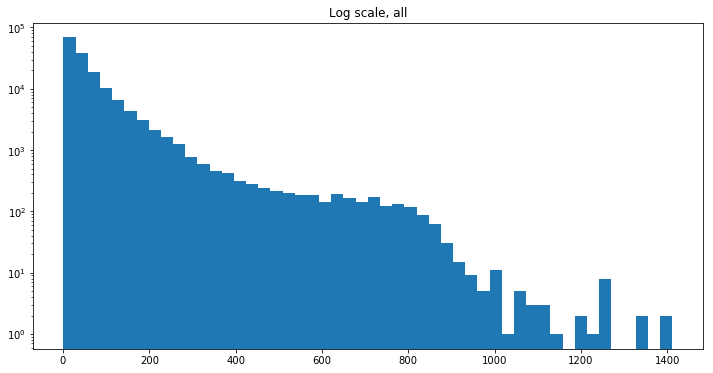

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

totalNumWords = [len(x.split()) for x in train['comment_text']]

plt.figure(figsize=(12,6))
plt.hist(totalNumWords, bins=np.arange(0,300,10))
plt.title("Linear scale, truncated")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(totalNumWords, bins=50)
plt.title("Log scale, all")
plt.yscale('log')
plt.show()

## Toxicity types

In [9]:
?sns.set_palette

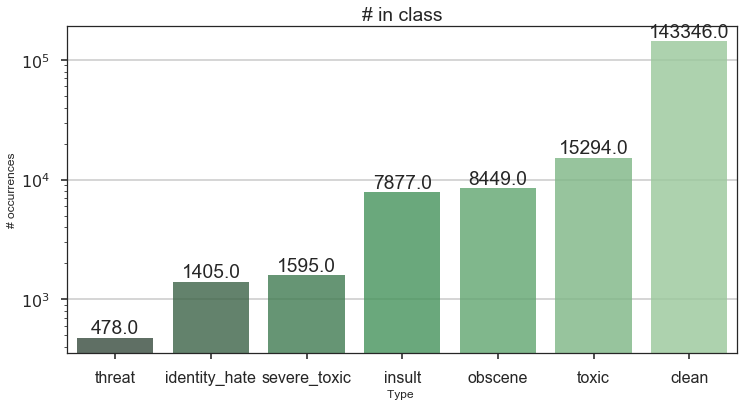

In [15]:
import seaborn as sns

x = train.iloc[:,2:].sum().sort_values(ascending=True)

# plot
sns.set_style("ticks", {'axes.grid': True})
sns.set_context("poster")
sns.color_palette("PuBuGn_d")

plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8, palette="Greens_d")
plt.title("# in class")
plt.ylabel('# occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.yscale('log')

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

How many comments have multiple types?

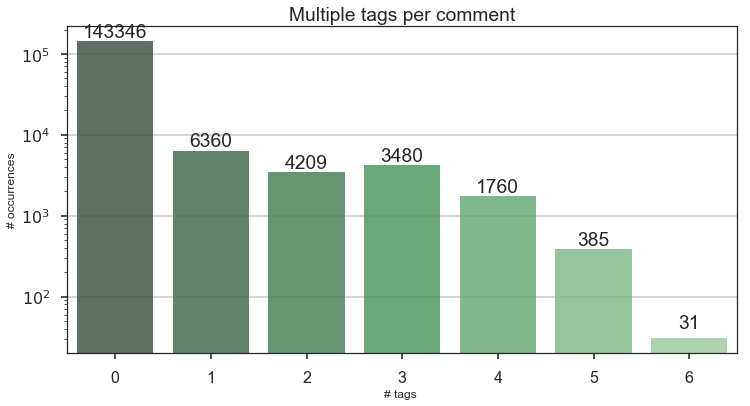

In [17]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8, palette="Greens_d")
plt.title("Multiple tags per comment")
plt.ylabel('# occurrences', fontsize=12)
plt.xlabel('# tags ', fontsize=12)
plt.yscale('log')

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Which toxicity types go together?

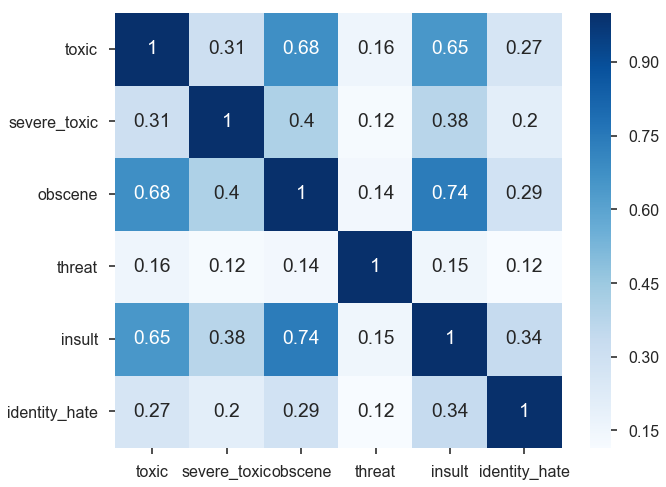

In [33]:
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Blues",
            annot=True)
plt.show()

The above plot indicates a pattern of co-occurence but Pandas's default Corr function, which uses Pearson correlation, does not apply here, since the variables involved are categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

Confusion matrix/Crosstab
Cramer's V Statistic
Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured.

In [28]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
    
# Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

## Words and chars

In [18]:
from __future__ import print_function

sall = ' '.join(list(train['comment_text']))
sall_words = sall.split()

print("Chars:", len(sall))
print("Words:", len(sall_words))

Chars: 63144172
Words: 10732858


Distinct words and their frequency:

Distinct words: 533185


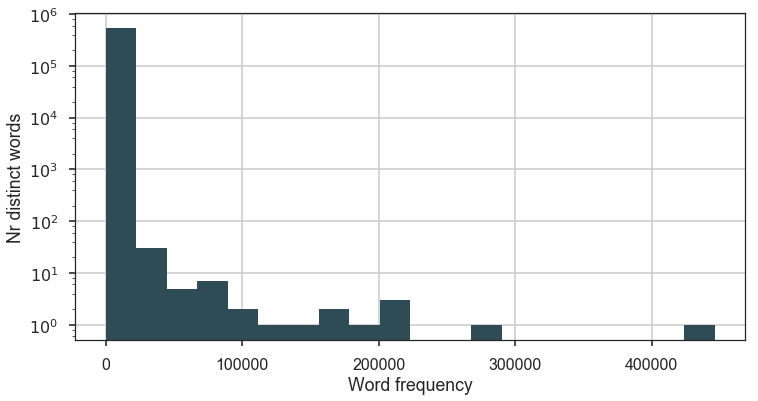

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

d = Counter(sall_words)
print("Distinct words:", len(d))

plt.figure(figsize=(12,6))
plt.hist(d.values(), bins=20)
plt.yscale('log')
plt.xlabel("Word frequency")
plt.ylabel("Nr distinct words")
plt.show()

In [20]:
print("Most common:")
for x in d.most_common(10):
    print(x)
    
least_common = [x for x in d.keys() if d[x] == 1]
print("")
print("Least common:")
for x in sample(least_common, 10):
    print(x)

Most common:
('the', 445975)
('to', 288804)
('of', 219329)
('and', 207375)
('a', 201816)
('I', 183920)
('is', 164639)
('you', 157272)
('that', 140544)
('in', 130261)

Least common:
Macau!
un-deleted.
""invention"",
Dugdale),
IGOR
Re:Meetup
User:Theredbanana.
""fudge
atque
DMAcks


What about chars? Note that unicode seems to be present:

In [11]:
from pprint import pprint

chars = Counter(sall)

pprint(dict(chars))
print("Distinct chars:", len(chars))

{'\n': 402237,
 ' ': 10829598,
 '!': 105576,
 '"': 392552,
 '#': 6232,
 '$': 977,
 '%': 5702,
 '&': 6735,
 "'": 219429,
 '(': 85085,
 ')': 90711,
 '*': 5275,
 '+': 3301,
 ',': 474958,
 '-': 102382,
 '.': 680368,
 '/': 58994,
 '0': 101296,
 '1': 104130,
 '2': 82627,
 '3': 37947,
 '4': 34769,
 '5': 35502,
 '6': 30056,
 '7': 30004,
 '8': 30983,
 '9': 39668,
 ':': 95215,
 ';': 21899,
 '<': 528,
 '=': 31010,
 '>': 1668,
 '?': 71692,
 '@': 1654,
 'A': 204042,
 'B': 90199,
 'C': 137924,
 'D': 88653,
 'E': 123024,
 'F': 80295,
 'G': 71389,
 'H': 105607,
 'I': 399097,
 'J': 36843,
 'K': 48923,
 'L': 78267,
 'M': 94083,
 'N': 106919,
 'O': 114384,
 'P': 116817,
 'Q': 5707,
 'R': 99973,
 'S': 169128,
 'T': 233885,
 'U': 81166,
 'V': 29019,
 'W': 141464,
 'X': 4373,
 'Y': 70380,
 'Z': 4889,
 '[': 8301,
 '\\': 572,
 ']': 8876,
 '^': 815,
 '_': 19087,
 '`': 574,
 'a': 3789126,
 'b': 693530,
 'c': 1383445,
 'd': 1720124,
 'e': 5642604,
 'f': 867963,
 'g': 933546,
 'h': 2092097,
 'i': 3533215,
 'j': 7